<a href="https://colab.research.google.com/github/Anushkasethi/APS360_Labs/blob/main/Lab5_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Spam Detection

**Deadline**: Monday, July 18 at 5:00 PM

**Late Penalty**: Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Justin Beland <justin.beland@mail.utoronto.ca>

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1wqcyxiWEIQvVqad4kiIDxjS9gHTC7PrU?usp=sharing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

To see what the msgs are like, I decided to print some of the sms's first:

In [ ]:
#checking label values:
count =0
for line in open('SMSSpamCollection'):
    print(line)
    count += 1
    print("count: ", count)
    if count==5  :
     break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

count:  1
ham	Ok lar... Joking wif u oni...

count:  2
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

count:  3
ham	U dun say so early hor... U c already then say...

count:  4
ham	Nah I don't think he goes to usf, he lives around here though

count:  5


Seems like the label for spam is spam and the label for non-spam is ham.

In [ ]:
count1 = 0
count2 =0
for line in open('SMSSpamCollection'):
 if line.split()[0] == "ham" and count1==0:
   print(line)
   count1 += 1
 elif line.split()[0] == "spam" and count2==0:
   print(line)
   count2 +=1
 elif count1==1 and count2==1:
  break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam = 0
ham = 0
for line in open('SMSSpamCollection'):
  if line.split()[0] == 'ham':
    ham += 1
  elif line.split()[0] == 'spam':
    spam+= 1

In [ ]:
print(ham)

4827


In [ ]:
print(spam)

747


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**Advantages:**
1. Mispelled words: If words are mispelled then it is known as a special (unknown) token. Hence the model is not flexible, however if we are dealing with a sequence of characters, it aids the model in ignoring the spelling mistakes within the dataset. 
2. Memory: We only have 26 letters in total in the alphabet, and if we end up including all the punctuation marks, almost less than 100 english characters are calculated. However, if we need up looking at the number of words, they would go upto thousands which means larger embeddings and more memory.



**Disadvantages:**

1. Harder to train: It is harder to train a sequence of characters than a sequence of words. Backpropagation becomes difficult with such a larger sequence of characters.

2. Context: It is hard for characters to know the context of words hence it may lead to a generation of unusual words. This would not prove to be a good model.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
%pip install torchtext==0.9
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)
print(dataset[0].sms)
print(dataset[0].label)
train, valid, test = dataset.split([.6, .2, .2], True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
0


In [ ]:
len(train)

3343

In [ ]:
len(valid)

1115

In [ ]:
len(test)

1114

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

If our training set is not balanced it will not help us get optimized results since it will tend to overlook the underlying class hence perform poorly in the future as it might not have seen many spam messages ending up classifying them as non-spam. In order to avoid this from happening we will be including the code below.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
#text_field.vocab.stoi: This helps in converting all the string tokens/character into its numerical identifier (integer) i.e getting indicies for all the text.
#text_field.vocab.itos: This helps to convert the indicies to the corresponding strings i.e a list of token strings to its corresponding numerical identifier.
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f84e95c5c50>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, 'c': 16, '.': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, 'T': 27, 'k': 28, '8': 29, 'v': 30, 'E': 31, 'S': 32, '5': 33, 'C': 34, 'I': 35, 'O': 36, '4': 37, '7': 38, 'N': 39, 'x': 40, 'A': 41, '3': 42, '6': 43, 'R': 44, ',': 45, '!': 46, '9': 47, 'P': 48, 'W': 49, 'U': 50, 'M': 51, 'L': 52, 'H': 53, 'D': 54, 'B': 55, 'F': 56, 'Y': 57, '?': 58, 'G': 59, "'": 60, '/': 61, '£': 62, '&': 63, '-': 64, ':': 65, 'X': 66, 'V': 67, 'z': 68, 'K': 69, 'j': 70, '*': 71, ')': 72, ';': 73, 'J': 74, '+': 75, '(': 76, '"': 77, 'q': 78, 'Q': 79, '#': 80, '>': 81, '=': 82, '@': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '<': 87, '\x92': 88, '‘': 89, '_': 90, '$': 91, '%': 92, '|': 93, '\x93': 94, '¡': 95, '…': 96, 'ú': 97, '\t': 98

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
#<unk> represents unknown tokens.

#<pad> represents padding the text messages which have less length than the maximum
#length within a batch of data. This is needed as when we are getting training data in batches,
# within a single batch we must have same length data.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
for batch in train_iter:
    
    print(len(batch))
    print(batch.sms)
    print(batch.label)
    print(batch.sms[0].shape)
    print(batch.sms[1][0])
    print(batch.sms[1].shape)
    print(batch.label.shape)
    print(batch.sms[0])
    print(batch.sms[1])
    print(batch.sms[0][1])
    break

32
(tensor([[54,  4,  2,  ..., 38, 14, 33],
        [27, 13,  6,  ..., 23, 29, 14],
        [27, 13,  6,  ..., 47, 47, 37],
        ...,
        [27, 13,  6,  ..., 23, 29, 14],
        [66, 18,  6,  ..., 10,  5, 46],
        [27, 13,  6,  ..., 23, 29, 14]]), tensor([157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157,
        157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157,
        157, 157, 157, 157]))
tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1])
torch.Size([32, 157])
tensor(157)
torch.Size([32])
torch.Size([32])
tensor([[54,  4,  2,  ..., 38, 14, 33],
        [27, 13,  6,  ..., 23, 29, 14],
        [27, 13,  6,  ..., 47, 47, 37],
        ...,
        [27, 13,  6,  ..., 23, 29, 14],
        [66, 18,  6,  ..., 10,  5, 46],
        [27, 13,  6,  ..., 23, 29, 14]])
tensor([157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157,
        157, 157, 157, 157, 157, 157, 157,

In [ ]:
batches = 1
for batch in train_iter:
    if batches>10:
      break
    else:
      print(batches)
      print("max length:", int(batch.sms[1][0]))
      result = 0
      print(batch.sms[1])
      for message in range(0, len(batch.sms[1])):
       result = result + batch.sms[1][0] - batch.sms[1][message]
      print("<pad> tokens:", int(result))
      batches += 1

1
max length: 161
tensor([161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161])
<pad> tokens: 0
2
max length: 29
tensor([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28])
<pad> tokens: 13
3
max length: 910
tensor([910, 611, 482, 458, 444, 431, 375, 368, 338, 329, 329, 324, 324, 316,
        289, 281, 276, 248, 245, 245, 240, 237, 237, 236, 234, 232, 230, 226,
        212, 205, 204, 202])
<pad> tokens: 18802
4
max length: 159
tensor([159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159,
        159, 159, 159, 159, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158,
        158, 158, 158, 158])
<pad> tokens: 14
5
max length: 122
tensor([122, 122, 122, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121,
        121, 121, 121, 121, 121, 120, 120, 120, 120, 120, 120, 

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "TweetRNN"
        super(TweetRNN, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model,batch_size,  data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    data_iter = torchtext.legacy.data.BucketIterator(data,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

    correct = 0
    total = 0
    for sms_data, labels in data_iter:

        output = model(sms_data[0])
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]

    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def train_rnn(model, train, valid, batch_size=64, learning_rate=0.001, num_epochs=1):
   
    train_loader = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    valid_loader = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []

    # training
    
    for epoch in range(num_epochs):
  
        for sms_data, labels in train_loader:
            out = model(sms_data[0])             # forward pass
            #print("hi_train")
            
            train_loss = criterion(out, labels) # compute the total loss
            train_loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        for sms_data, labels in valid_loader:
            
            out = model(sms_data[0])             # forward pass
            #print("hi_val")
            
            val_loss = criterion(out, labels) # compute the total loss


        # save the current training information
        iters.append(epoch)
        train_losses.append(float(train_loss))             # compute *average* loss
        val_losses.append(float(val_loss))             # compute *average* loss
        train_acc.append(get_accuracy(model, batch_size, train)) # compute training accuracy
        print("epoch number ", epoch+1, "accuracy: ",train_acc[epoch])
        print("Loss: ", train_losses[epoch-1], "epoch number ", epoch)
 
        val_acc.append(get_accuracy(model, batch_size, valid))  # compute validation accuracy
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

       

In [ ]:
input_size = len(text_field.vocab.itos)

In [ ]:
print(input_size)

112


epoch number  1 accuracy:  0.5453490300116067
Loss:  0.7111393213272095 epoch number  0
epoch number  2 accuracy:  0.6166473221687946
Loss:  0.7111393213272095 epoch number  1
epoch number  3 accuracy:  0.6375393798706682
Loss:  0.6195990443229675 epoch number  2
epoch number  4 accuracy:  0.649809318520975
Loss:  0.6982496976852417 epoch number  3
epoch number  5 accuracy:  0.6537887580832367
Loss:  0.6623086333274841 epoch number  4
epoch number  6 accuracy:  0.6770021555297628
Loss:  0.5799354314804077 epoch number  5
epoch number  7 accuracy:  0.6630741170618472
Loss:  0.7897071838378906 epoch number  6
epoch number  8 accuracy:  0.6967335433593103
Loss:  0.5324826836585999 epoch number  7
epoch number  9 accuracy:  0.6662245067153043
Loss:  0.674041748046875 epoch number  8
epoch number  10 accuracy:  0.7347040291825568
Loss:  0.8086583614349365 epoch number  9
epoch number  11 accuracy:  0.6702039462775659
Loss:  0.7635628581047058 epoch number  10
epoch number  12 accuracy:  0.7

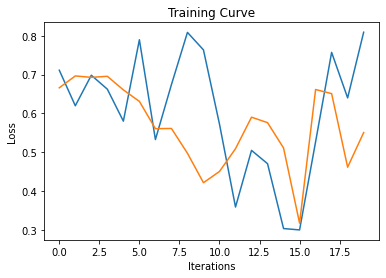

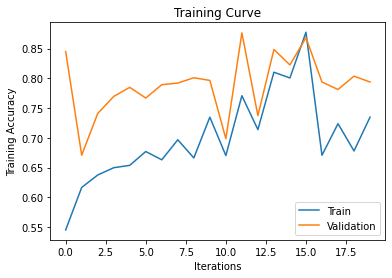

Final Training Accuracy: 0.7347040291825568
Final Validation Accuracy: 0.7937219730941704


In [ ]:
model = TweetRNN(input_size, 100, 2)   
train_rnn(model, train, valid, 64, 0.001, 20)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

The hyperparameters I trained were:

1. Learning rate
2. Number of epochs
3. The architecture of the model (changing how the output was returned as discussed in Part 2 (model Building))
4. Hidden size in the architecture

**model_2:** TweetRNN(input_size, 200, 2)

Batch_size: 64, Lr: 0.001, Epoch: 20

For this model I used the same learning rate, no. of epochs and the batch size as model had given a final validation accuracy of 79% which is decent. However one change which I made was to use 200 as the hidden size of the model. This was beneficial as our final validation accuracy increased by 10% from 79 to 89%.

**model_3:** TweetRNN_2(input_size, 200, 2)

Batch_size: 32, Lr: 0.005, Epoch: 10
 
For this model I ended up defining a new model (TweetRNN_2) which returned the concatenation of the max-pooling and average-pooling of the RNN outputs. I will the hidden_size the same as before in all models going forward (200) as that gave better results over 100. (observed by comparing model and model_2) I also changed the batch size to 32, the learning rate to 0.005 and the number of epochs to 10. This was done to check how the model would respons to these hyperparameters, which we can change later on if the accuracy wasnt as per our expectations. 

**model_4:** TweetRNN_3(input_size, 100, 2)

Batch_size: 32, Lr: 0.0005, Epoch: 15

For model_3 we got a validation accuracy of 21% which is far below what we expected hence to optimize the hyperparameters we decide that TweetRNN_2 was not the best model and I ended up defining another model which will max-pool over the entire output array TweetRNN_3(input_size, 100, 2). 

For the other hyperparameters it was observed that since increasing the lr from 0.001 to 0.005 gave bad results, I decided to decrease the lr to 0.0005 and check whether that would help in improving the results. Moreover I changed the number of epochs from 10 to 15 (in between the number of epochs for model_2 and model_3).

**Using model_4 we obtained a validation accuracy of 96%, which is a really good accuracy as compared to all the other models. Hence, the hyperparameters chosen for model_4 were the best ones out of all.**

In [ ]:
def train_rnn_nocurves(model, train, valid, batch_size=64, learning_rate=0.001, num_epochs=1):
   
    train_loader = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    valid_loader = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []

    # training
    
    for epoch in range(num_epochs):
  
        for sms_data, labels in train_loader:
            out = model(sms_data[0])             # forward pass
            #print("hi_train")
            
            train_loss = criterion(out, labels) # compute the total loss
            train_loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        for sms_data, labels in valid_loader:
            
            out = model(sms_data[0])             # forward pass
            #print("hi_val")
            
            val_loss = criterion(out, labels) # compute the total loss


        # save the current training information
        iters.append(epoch)
        train_losses.append(float(train_loss))             # compute *average* loss
        val_losses.append(float(val_loss))             # compute *average* loss
        train_acc.append(get_accuracy(model, batch_size, train)) # compute training accuracy
        print("epoch number ", epoch+1, "accuracy: ",train_acc[epoch])
        print("Loss: ", train_losses[epoch-1], "epoch number ", epoch)
 
        val_acc.append(get_accuracy(model, batch_size, valid))  # compute validation accuracy
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
model_2 = TweetRNN(input_size, 200, 2)   
train_rnn_nocurves(model_2, train, valid, 64, 0.001, 20)

epoch number  1 accuracy:  0.5806665561266788
Loss:  0.6867740154266357 epoch number  0
epoch number  2 accuracy:  0.5218040126015586
Loss:  0.6867740154266357 epoch number  1
epoch number  3 accuracy:  0.6471563588128005
Loss:  0.600639283657074 epoch number  2
epoch number  4 accuracy:  0.6862875145083734
Loss:  0.6871445775032043 epoch number  3
epoch number  5 accuracy:  0.6440059691593434
Loss:  0.6648056507110596 epoch number  4
epoch number  6 accuracy:  0.6743491958215885
Loss:  0.5793871283531189 epoch number  5
epoch number  7 accuracy:  0.7189520809152711
Loss:  0.8417944312095642 epoch number  6
epoch number  8 accuracy:  0.785110263637871
Loss:  0.4454331696033478 epoch number  7
epoch number  9 accuracy:  0.6522964682473885
Loss:  0.5402439832687378 epoch number  8
epoch number  10 accuracy:  0.6725252860222185
Loss:  0.7847071886062622 epoch number  9
epoch number  11 accuracy:  0.7118222516995523
Loss:  0.7589148879051208 epoch number  10
epoch number  12 accuracy:  0.6

In [ ]:
class TweetRNN_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "TweetRNN_2"
        super(TweetRNN_2, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        #out = self.fc(out[:, -1, :])
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        return out

In [ ]:
model_3 = TweetRNN_2(input_size, 200, 2)
train_rnn_nocurves(model_3, train, valid, 32, 0.005, 10)

epoch number  1 accuracy:  0.5496600895373902
Loss:  4.674309253692627 epoch number  0
epoch number  2 accuracy:  0.4828386668877466
Loss:  4.674309253692627 epoch number  1
epoch number  3 accuracy:  0.47885922732548497
Loss:  4.553764343261719 epoch number  2
epoch number  4 accuracy:  0.5680649975128502
Loss:  4.507992267608643 epoch number  3
epoch number  5 accuracy:  0.5680649975128502
Loss:  4.464175224304199 epoch number  4
epoch number  6 accuracy:  0.5680649975128502
Loss:  4.426294803619385 epoch number  5
epoch number  7 accuracy:  0.5680649975128502
Loss:  4.3972063064575195 epoch number  6
epoch number  8 accuracy:  0.5680649975128502
Loss:  4.368196487426758 epoch number  7
epoch number  9 accuracy:  0.5675675675675675
Loss:  4.347356796264648 epoch number  8
epoch number  10 accuracy:  0.5675675675675675
Loss:  4.322461128234863 epoch number  9
Final Training Accuracy: 0.5675675675675675
Final Validation Accuracy: 0.21076233183856502


In [ ]:
class TweetRNN_3(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        self.name = "TweetRNN_3"
        super(TweetRNN_3, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(torch.max(out, dim=1)[0])
        return out

In [ ]:
model_4 = TweetRNN_3(input_size, 200, 2)
train_rnn_nocurves(model_4, train, valid, 32, 0.0005, 15)

epoch number  1 accuracy:  0.5199801028021886
Loss:  0.7666622996330261 epoch number  0
epoch number  2 accuracy:  0.5199801028021886
Loss:  0.7666622996330261 epoch number  1
epoch number  3 accuracy:  0.5199801028021886
Loss:  0.6758900284767151 epoch number  2
epoch number  4 accuracy:  0.5247885922732548
Loss:  0.7198995351791382 epoch number  3
epoch number  5 accuracy:  0.5534737191178909
Loss:  0.7378212213516235 epoch number  4
epoch number  6 accuracy:  0.5793400762725917
Loss:  0.5767644643783569 epoch number  5
epoch number  7 accuracy:  0.9469408058365114
Loss:  0.6780040264129639 epoch number  6
epoch number  8 accuracy:  0.9351682971314873
Loss:  0.5765692591667175 epoch number  7
epoch number  9 accuracy:  0.9240590283535068
Loss:  0.5592514276504517 epoch number  8
epoch number  10 accuracy:  0.920577018736528
Loss:  0.37191689014434814 epoch number  9
epoch number  11 accuracy:  0.9303598076604211
Loss:  0.30245307087898254 epoch number  10
epoch number  12 accuracy:  

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
   
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
    return path

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)
model_path = get_model_name(model_4.name, batch_size=32, learning_rate=0.0005, epoch=14)
state = torch.load(model_path)
model_4.load_state_dict(state)

false_positive = 1- get_accuracy(model_4, 32, valid_nospam)
false_negative = 1- get_accuracy(model_4, 32, valid_spam)

In [ ]:
print(false_positive)

0.025906735751295318


In [ ]:
print(false_negative)

0.09999999999999998


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

False positives refer to for example, a spam message being classified as non-spam messages. This would be very irritating filling our phone with unnecessary messages to go through and sometimes may even cause confusion by judging the message as genuine making us commit a mistake for example, by clicking on a link of a spam message as we thought it was non-spam.

Whereas on the other hand, false negatives refer to a non-spam message being classifies as spam. This is more harmful to us as it would lead to us missing some important messages for example, information about your next flight and the details.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
model_path = get_model_name(model_4.name, batch_size=32, learning_rate=0.0005, epoch=0)
state = torch.load(model_path)
model_4.load_state_dict(state)

<All keys matched successfully>

In [ ]:
test_accuracy = get_accuracy(model_4, 32, test)
print("test accuracy:", test_accuracy)

test accuracy: 0.9676840215439856


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)
model_path = get_model_name(model_4.name, batch_size=32, learning_rate=0.0005, epoch=14)
state = torch.load(model_path)
model_4.load_state_dict(state)

false_positive_test = 1- get_accuracy(model_4, 32, test_nospam)
false_negative_test = 1- get_accuracy(model_4, 32, test_spam)

In [ ]:
print(false_positive_test)

0.01968911917098448


In [ ]:
print(false_negative_test)

0.10067114093959728


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
messages = []
msg_list=[]
for character in msg:
  messages.append(text_field.vocab.stoi[character])
print(messages)
case = torch.LongTensor([messages])
result = F.softmax(model_4(case), dim=1)[0][1].item()

[18, 6, 16, 13, 9, 7, 3, 2, 11, 3, 6, 8, 7, 9, 7, 22, 2, 9, 10, 2, 10, 4, 4, 4, 2, 16, 4, 4, 11, 46]


In [ ]:
print(result)

0.058751996606588364


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Filtering technique based on content of the words: Using SVM, we can create some automatic filtering  rules that can be used to judge whether its spam or not. The baseline model will help analyze certain words along with how many times they have occured in the messages. For example we can create rules by judging the phrases on messages/emails with words "Congratulations", "free" etc. and whether or not they are referring to someone in particular or just a general random person.

Heuristic based filtering: Another way would be to use heuristics to judge certain patterns that appear in spam messages/emails. Identifying such patterns would increase the score for a particular message. If the score increases beyond a particular value then it will end up being classified as a spam message.